# ***IMPORTS***

In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, ReLU, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from efficientnet.tfkeras import EfficientNetB0
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
from glob import glob
from tqdm import tqdm
import pydicom
from PIL import Image

# ***Loading Data***

In [3]:
data = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

<AxesSubplot:>

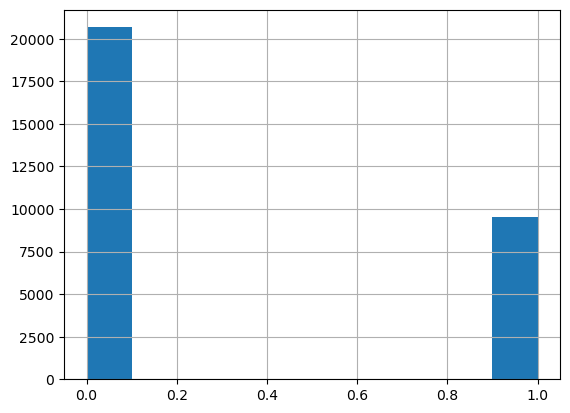

In [4]:
data['Target'].hist()

In [5]:
data.head(20)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


# ***Splitting Data***

In [6]:
def dicom_to_image(input_path, output_path):
    dicom_data = pydicom.dcmread(input_path)
    pixel_array = dicom_data.pixel_array
    image = Image.fromarray(pixel_array)
    image.save(output_path)

In [7]:
def split_data(data_path: str, c: pd.core.frame.DataFrame) -> None:
    if not os.path.exists('/kaggle/working/train_directory'):
        os.makedirs('/kaggle/working/train_directory')
    if not os.path.exists('/kaggle/working/test_directory'):
        os.makedirs('/kaggle/working/test_directory')

    i = 0
    for _, row in tqdm(c.iterrows(), total=30227):
        filename = row['patientId']
        label = row['Target']
        if os.path.exists(os.path.join(data_path,filename+'.dcm')):
            if not os.path.exists(os.path.join('/kaggle/working/train_directory', str(label))):
                os.makedirs(os.path.join('/kaggle/working/train_directory', str(label)))
            if not os.path.exists(os.path.join('/kaggle/working/test_directory', str(label))):
                os.makedirs(os.path.join('/kaggle/working/test_directory', str(label)))

            target_directory = os.path.join('/kaggle/working/train_directory', str(label)) if i < 20000 else os.path.join('/kaggle/working/test_directory', str(label))
            dicom_to_image(os.path.join(data_path, filename+'.dcm'), os.path.join(target_directory, filename+'.jpg'))
            i += 1

In [8]:
split_data('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images', data)

 70%|██████▉   | 21094/30227 [10:26<04:23, 34.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 30227/30227 [14:56<00:00, 33.70it/s]


In [9]:
for file in glob('/kaggle/working/test_directory/0/*')[:1500]:
    shutil.move(file, '/kaggle/working/train_directory/0')

In [10]:
def plot_hist(data_path: str, title: str) -> None:
    subfolders = [f.path for f in os.scandir(data_path) if f.is_dir()]
    subfolder_names = []
    file_counts = []
    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        subfolder_names.append(subfolder_name)
        file_count = len(os.listdir(subfolder))
        file_counts.append(file_count)

    plt.bar(subfolder_names, file_counts)
    plt.xlabel('classes')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.xticks()
    plt.show()

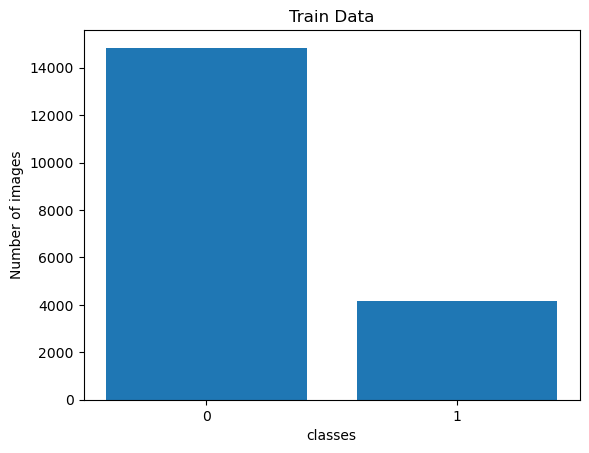

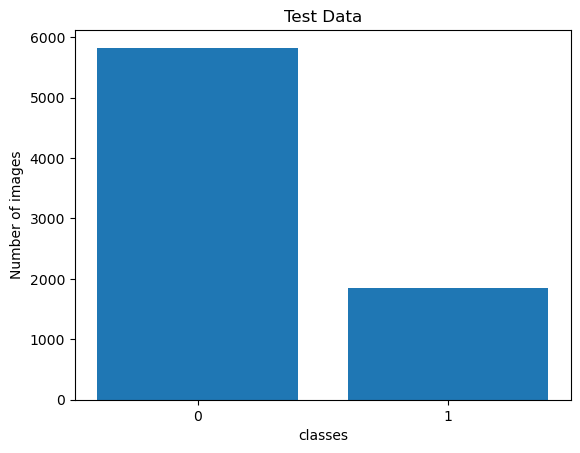

In [11]:
plot_hist('/kaggle/working/train_directory', 'Train Data')
plot_hist('/kaggle/working/test_directory', 'Test Data')

# ***Preprocessing and Normalization***

In [12]:
datagen = ImageDataGenerator(
            rescale=1.0/255.0,
            zoom_range=0.15,
            fill_mode='constant',
            cval=0.
            )

img_size = 128
batch_size = 32

train_generator = datagen.flow_from_directory(
    '/kaggle/working/train_directory',
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

test_generator = datagen.flow_from_directory(
    '/kaggle/working/test_directory',
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

Found 19017 images belonging to 2 classes.
Found 7667 images belonging to 2 classes.


In [13]:
x, y = next(train_generator)

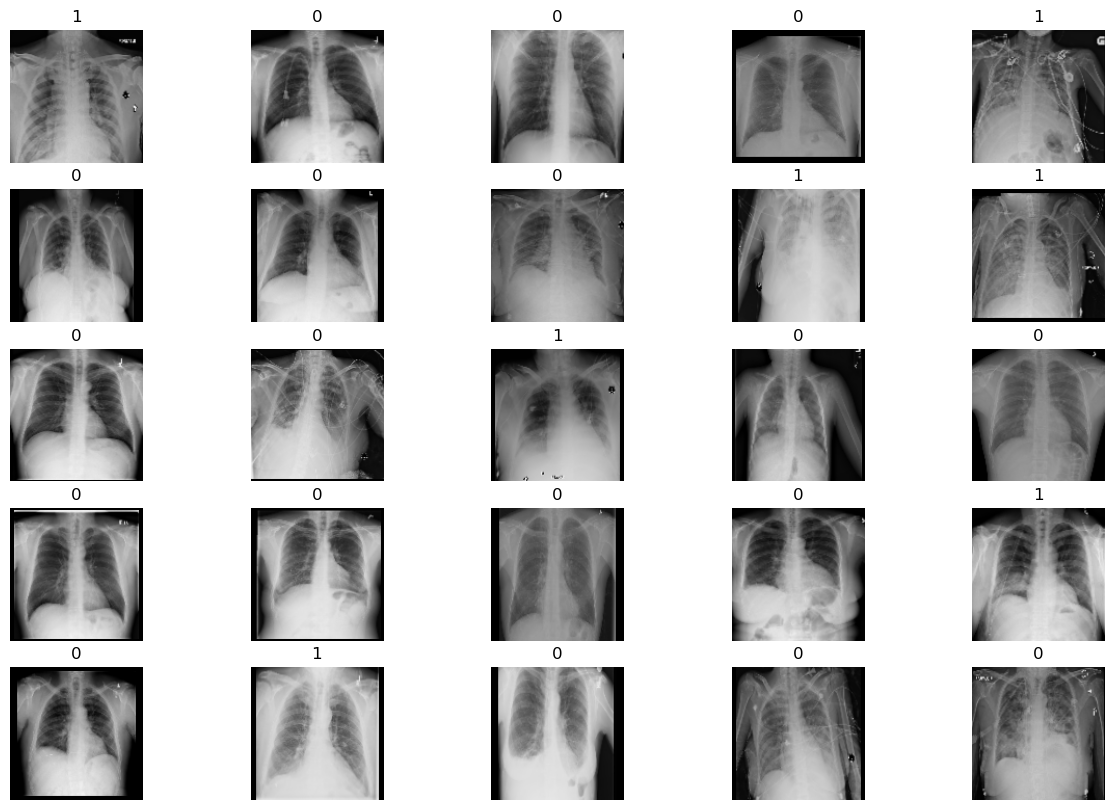

In [14]:
a = train_generator.class_indices
class_names = list(a.keys())

def plot_images(img: np.ndarray, labels: np.ndarray) -> None:
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')

plot_images(x, np.where(y >= 0.5, 1, 0))

In [15]:
x_train, y_train = np.array(x), np.array(y)
for _ in tqdm(range(594)):
    x, y = next(train_generator)
    x_train = np.append(x_train, x, axis=0)
    y_train = np.append(y_train, y, axis=0)

100%|██████████| 594/594 [09:36<00:00,  1.03it/s]


In [16]:
x, y = next(train_generator)

In [17]:
x_test, y_test = np.array(x), np.array(y)
for _ in tqdm(range(238)):
    x, y = next(train_generator)
    x_test = np.append(x_test, x, axis=0)
    y_test = np.append(y_test, y, axis=0)

100%|██████████| 239/239 [02:15<00:00,  1.76it/s]


In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19017, 128, 128, 3), (19017,), (7680, 128, 128, 3), (7680,))

# ***Building a Neural Network***

In [19]:
def build_Model() -> Sequential:
    model = Sequential()

    base = EfficientNetB0(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

    model.add(base)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [44]:
model = build_Model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 4, 4, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(),
              tf.keras.metrics.AUC(),
              tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint("pneumonia_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=5)

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

# ***Training - 1***

In [46]:
history = model.fit(
            x_train, y_train,
            epochs=200,
            validation_data=(x_test, y_test),
            shuffle=True,
            batch_size=32,
            callbacks=[checkpoint, early_stop, reduceLROnPlat]
          )

Epoch 1/200


2023-12-29 10:43:19.054939: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


594/595 [============================>.] - ETA: 0s - loss: 0.4069 - accuracy: 0.8177 - precision_5: 0.6215 - auc_5: 0.8239 - recall_5: 0.4320
Epoch 1: val_accuracy improved from -inf to 0.80495, saving model to pneumonia_weights.h5
595/595 [==============================] - 90s 89ms/step - loss: 0.4069 - accuracy: 0.8177 - precision_5: 0.6214 - auc_5: 0.8239 - recall_5: 0.4320 - val_loss: 0.4155 - val_accuracy: 0.8049 - val_precision_5: 0.5402 - val_auc_5: 0.8555 - val_recall_5: 0.6809 - lr: 0.0010
Epoch 2/200
594/595 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8370 - precision_5: 0.6776 - auc_5: 0.8655 - recall_5: 0.4900
Epoch 2: val_accuracy improved from 0.80495 to 0.85299, saving model to pneumonia_weights.h5
595/595 [==============================] - 49s 82ms/step - loss: 0.3621 - accuracy: 0.8370 - precision_5: 0.6775 - auc_5: 0.8655 - recall_5: 0.4901 - val_loss: 0.3514 - val_accuracy: 0.8530 - val_precision_5: 0.6916 - val_auc_5: 0.8807 - val_recall_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



594/595 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9897 - precision_5: 0.9788 - auc_5: 0.9982 - recall_5: 0.9741
Epoch 16: val_accuracy did not improve from 0.88060
595/595 [==============================] - 48s 81ms/step - loss: 0.0314 - accuracy: 0.9897 - precision_5: 0.9788 - auc_5: 0.9982 - recall_5: 0.9741 - val_loss: 0.6269 - val_accuracy: 0.8641 - val_precision_5: 0.6523 - val_auc_5: 0.8990 - val_recall_5: 0.8002 - lr: 6.4000e-04
Epoch 17/200
594/595 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9883 - precision_5: 0.9731 - auc_5: 0.9985 - recall_5: 0.9734
Epoch 17: val_accuracy did not improve from 0.88060
595/595 [==============================] - 49s 82ms/step - loss: 0.0317 - accuracy: 0.9883 - precision_5: 0.9732 - auc_5: 0.9985 - recall_5: 0.9734 - val_loss: 0.5481 - val_accuracy: 0.8757 - val_precision_5: 0.6956 - val_auc_5: 0.8993 - val_recall_5: 0.7594 - lr: 6.4000e-04
Epoch 18/200
594/595 [=========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 32: val_accuracy did not improve from 0.89036

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
595/595 [==============================] - 49s 82ms/step - loss: 0.0110 - accuracy: 0.9962 - precision_5: 0.9909 - auc_5: 0.9995 - recall_5: 0.9916 - val_loss: 0.7329 - val_accuracy: 0.8889 - val_precision_5: 0.7854 - val_auc_5: 0.8743 - val_recall_5: 0.6719 - lr: 4.0960e-04
Epoch 33/200
594/595 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9978 - precision_5: 0.9947 - auc_5: 0.9999 - recall_5: 0.9954
Epoch 33: val_accuracy improved from 0.89036 to 0.89180, saving model to pneumonia_weights.h5
595/595 [==============================] - 49s 82ms/step - loss: 0.0059 - accuracy: 0.9978 - precision_5: 0.9947 - auc_5: 0.9999 - recall_5: 0.9954 - val_loss: 0.6879 - val_accuracy: 0.8918 - val_precision_5: 0.7832 - val_auc_5: 0.8842 - val_recall_5: 0.6935 - lr: 3.2768e-04
Epoch 34/200
595/595 [==============================] - ETA: 0s - l

## ***Evaluation***

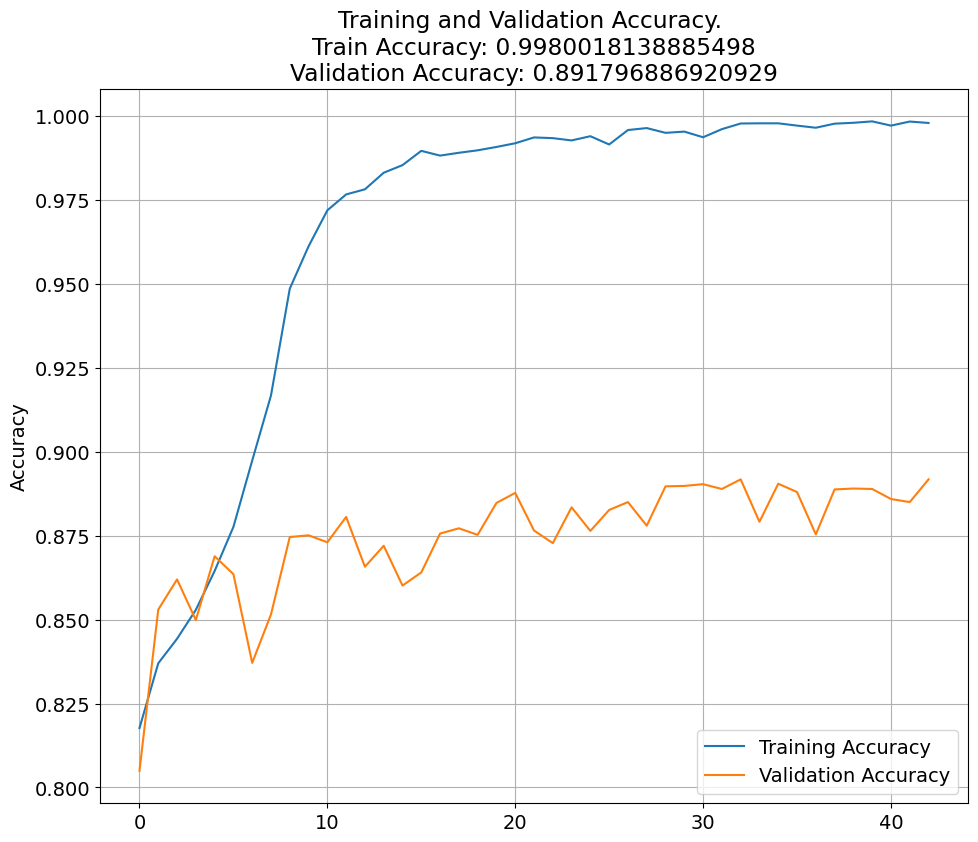

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.tight_layout()
plt.show()

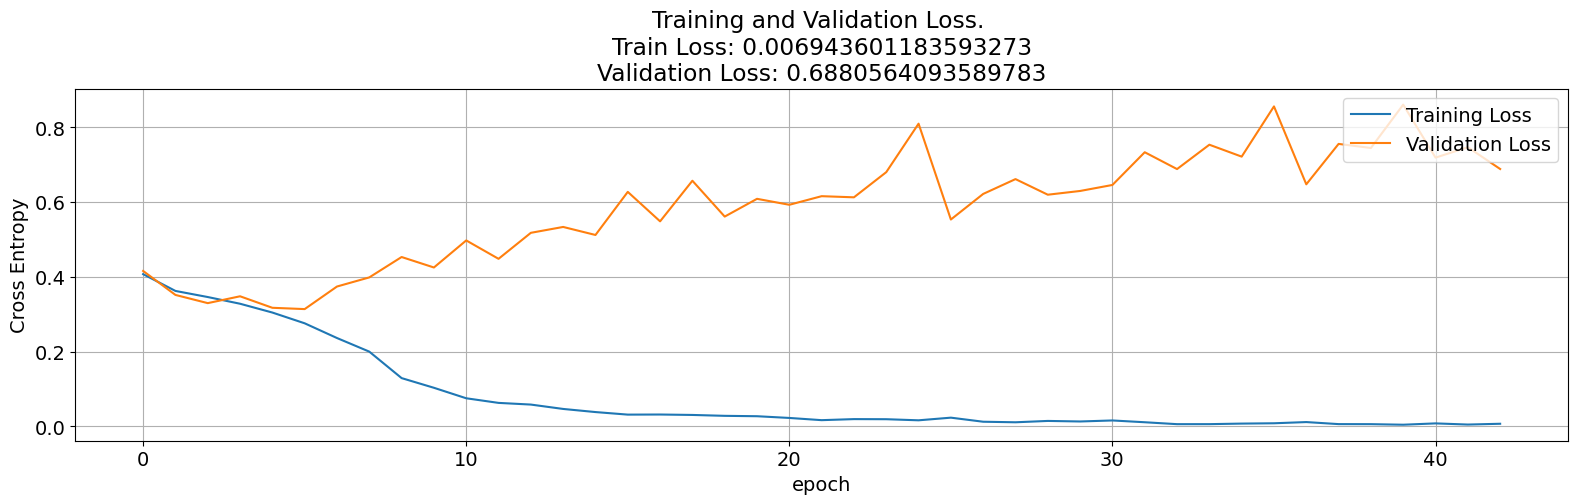

In [48]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

240/240 [==============================] - 5s 16ms/step


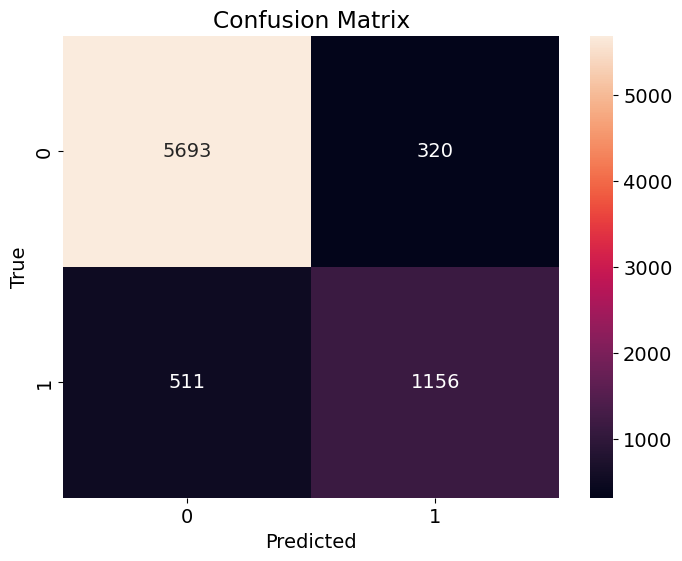

In [49]:
y_pred = model.predict(x_test).flatten() > 0.5

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
model.load_weights('pneumonia_weights.h5')

In [70]:
loss, accuracy, _, _, _ = model.evaluate(x_test, y_test)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

240/240 [==============================] - 4s 18ms/step - loss: 0.6879 - accuracy: 0.8918 - precision_5: 0.7832 - auc_5: 0.8842 - recall_5: 0.6935
Accuracy:  0.891796886920929
Loss:  0.6878539323806763


240/240 [==============================] - 4s 16ms/step


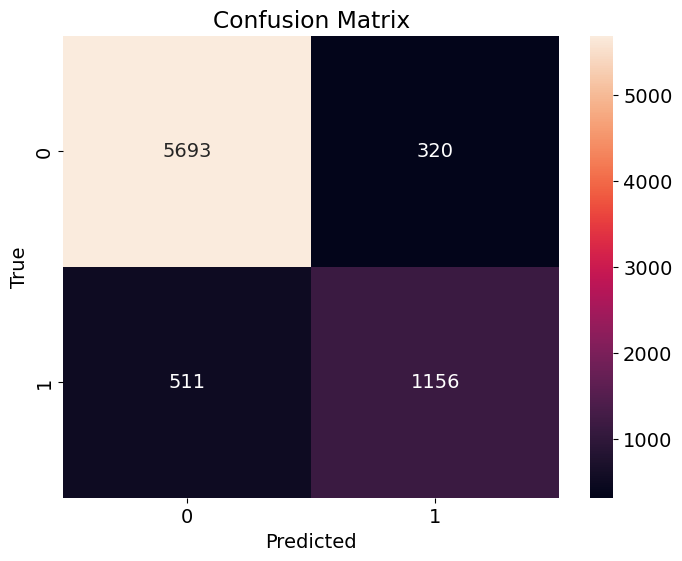

In [75]:
y_pred = model.predict(x_test).flatten() > 0.5

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ***Testing***

In [72]:
x_batch, y_batch = x_test[:32], y_test[:32]
predictions = model.predict(x_batch)

1/1 [==============================] - 0s 37ms/step


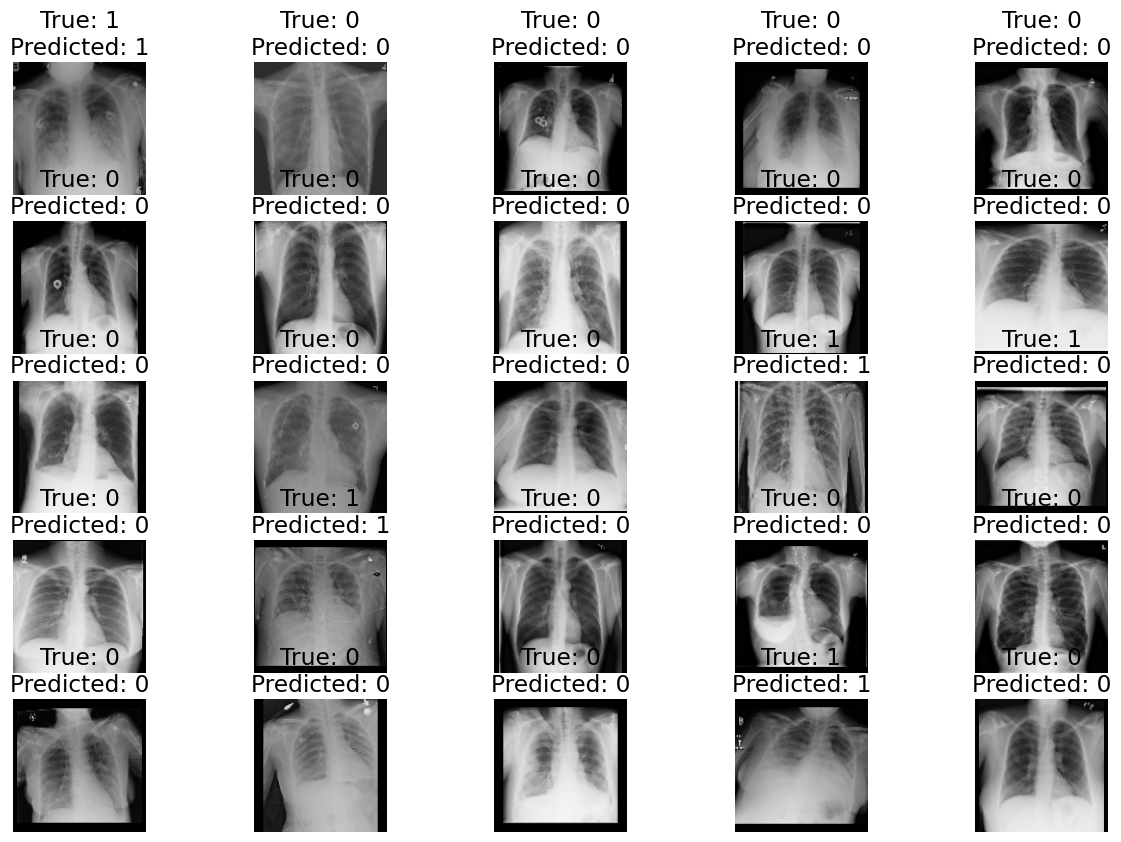

In [74]:
true_labels = np.where(y_batch >= 0.5, 1, 0)

class_names = list(test_generator.class_indices.keys())

predicted_labels = np.where(predictions >= 0.5, 1, 0)
predicted_labels = np.squeeze(predicted_labels)

plt.figure(figsize=[15, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_batch[i])
    true_label = class_names[true_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.show()

# ***Saving The Model***

In [57]:
model.save('pneumonia_model.h5')